In [22]:
import scipy.io
import pandas as pd
import numpy as np
import itertools
from ci_test import ci_test
import pickle
import cdt
import networkx as nx
import matplotlib.pyplot as plt

In [80]:
datasets = []

for dataset_i in range(1,5):
    d_mat = scipy.io.loadmat(f"D{dataset_i}.mat")
    datasets.append(np.array(pd.DataFrame(d_mat['D'])))

## 1.1 SGS Algorithm

In [258]:
def sgs(dataset: np.ndarray) -> (np.ndarray, [set]):
    n_columns = dataset.shape[1]
    all_nodes = range(n_columns)

    adjacency_matrix =  np.zeros((n_columns, n_columns))

    # Initialize a list of sets to keep for the edge orientation phase
    #Z_set = np.full((n_columns, n_columns), set())
    Z_set = [[set() for i in range(n_columns)] for j in range(n_columns)]

    for node_i in all_nodes:
        nodes = list(all_nodes)
        nodes.remove(node_i)
        # Pick a different 2nd variable
        for node_j in nodes:
            for n_controls in all_nodes:
                possible_controls = list(all_nodes).copy()
                possible_controls.remove(node_i)
                possible_controls.remove(node_j)

                condition_set = list(itertools.combinations(possible_controls, n_controls))

                conditionnal_indep_holds = True
                for condition in condition_set:
                    if ci_test(dataset, node_i, node_j, condition):
                        conditionnal_indep_holds = False
                        break
                if conditionnal_indep_holds:
                    adjacency_matrix[node_i][node_j] = adjacency_matrix[node_j][node_i] = 1
                    Z_set[node_i][node_j] |= set(condition_set)
                    Z_set[node_i][node_j] |= set(condition_set)

    return adjacency_matrix, Z_set

## 1.1 PC Algorithm

In [216]:
def pc1(dataset: np.ndarray) -> (np.ndarray, [set]):
    n_columns = dataset.shape[1]
    all_nodes = range(n_columns)

    # Initialize a fully connected adjency matrix (no self connection since its a DAG)
    adjacency_matrix = np.ones((n_columns, n_columns)) - np.identity(n_columns)

    Z_set = [[set() for i in range(n_columns)] for j in range(n_columns)]
    # Pick the 1st variable
    for node_i in all_nodes:
        nodes = list(all_nodes)
        nodes.remove(node_i)
        # Pick a different 2nd variable
        for node_j in nodes:
            # Pick a condition set
            for n_controls in all_nodes:
                possible_controls = list(all_nodes)
                possible_controls.remove(node_i)
                possible_controls.remove(node_j)

                possible_controls = list(itertools.combinations(possible_controls, n_controls))

                for condition_set in possible_controls:
                    if ci_test(dataset, node_i, node_j, condition_set):
                        adjacency_matrix[node_i][node_j] =  adjacency_matrix[node_j][node_i] = 0

                        Z_set[node_i][node_j] |= set(condition_set)
                        Z_set[node_j][node_i] |= set(condition_set)

    return adjacency_matrix, Z_set

1.2 Modified PC algorithm

## 2 Orienting the edges
### 2.1 Starting with V-structures

In [215]:
def add_v_structures(graph: nx.Graph, Z_set: [set]) -> nx.DiGraph:
    directed_graph = nx.DiGraph(graph)
    nodes = graph.nodes

    for node_pair in itertools.combinations(nodes, 2):
        i = node_pair[0]
        j = node_pair[1]

        i_child = set(directed_graph.successors(i))
        if j in i_child:
            continue
        j_child = set(directed_graph.successors(j))
        if i in j_child:
            continue
        if Z_set[i][j] is None: # is none
            continue

        common_children = i_child & j_child
        for child in common_children:
            if child not in Z_set[i][j]:
                if directed_graph.has_edge(child, i):
                    directed_graph.remove_edge(child, i)
                if directed_graph.has_edge(child, j):
                    directed_graph.remove_edge(child, j)

    return directed_graph

## 2.2 Adding the two meek rules

In [218]:
def add_meek_rules(directed_graph: nx.DiGraph) -> nx.DiGraph:
    for node_pair in itertools.combinations(directed_graph, 2):
        node_i, node_j = node_pair

        # meek 1
        if directed_graph.has_edge(node_i, node_j) & directed_graph.has_edge(node_j, node_i):
            to_remove = set()
            for parent in directed_graph.predecessors(node_i):
                if directed_graph.has_edge(node_i, parent) or (directed_graph.has_edge(parent, node_j) or directed_graph.has_edge(node_j, parent)):
                    continue
                else:
                   to_remove.add((node_j,node_i))

            for pair in to_remove:
                directed_graph.remove_edge(*pair)


        # meek 2
        if directed_graph.has_edge(node_i, node_j) & directed_graph.has_edge(node_j, node_i):
            for child in directed_graph.successors(node_i):
                if (not directed_graph.has_edge(child, node_i)) and directed_graph.has_edge(child, node_j):
                    directed_graph.remove_edge(node_j, node_i)

    return  directed_graph

In [ ]:

graph = nx.from_numpy_matrix(adjacency_mat)
directed_graph = add_v_structures(datasets[0], graph, condition_set)

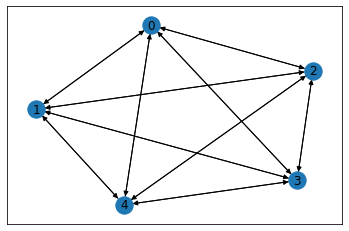

In [259]:
adjacency_mat, condition_set = sgs(datasets[0])
graph = nx.from_numpy_matrix(adjacency_mat)

directed_graph = add_v_structures(graph, condition_set)
directed_graph = add_meek_rules(directed_graph)

nx.draw_networkx(directed_graph, with_labels=True)

In [242]:
adjacency_mat

array([[0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0.]])

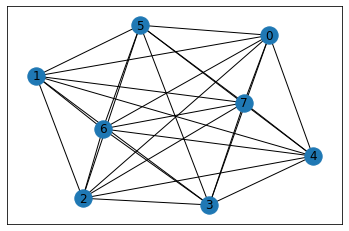

In [241]:
nx.draw_networkx(nx.from_numpy_matrix(adjacency_mat))